In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import torch

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy 
from magrec.transformation.Mxy2Bsensor import Mxy2Bsensor
from magrec.transformation.MxandMy2Bsensor import MxandMy2Bsensor
from magrec.misc.data import Data
from magrec import __datapath__


import magrec.image_processing.Masks as Masks
from magrec.method.FCNN import FCNN
from magrec.method.CNN import CNN
from magrec.models.UniformMagnetisation import UniformMagnetisation
from magrec.models.Mxy import Mxy

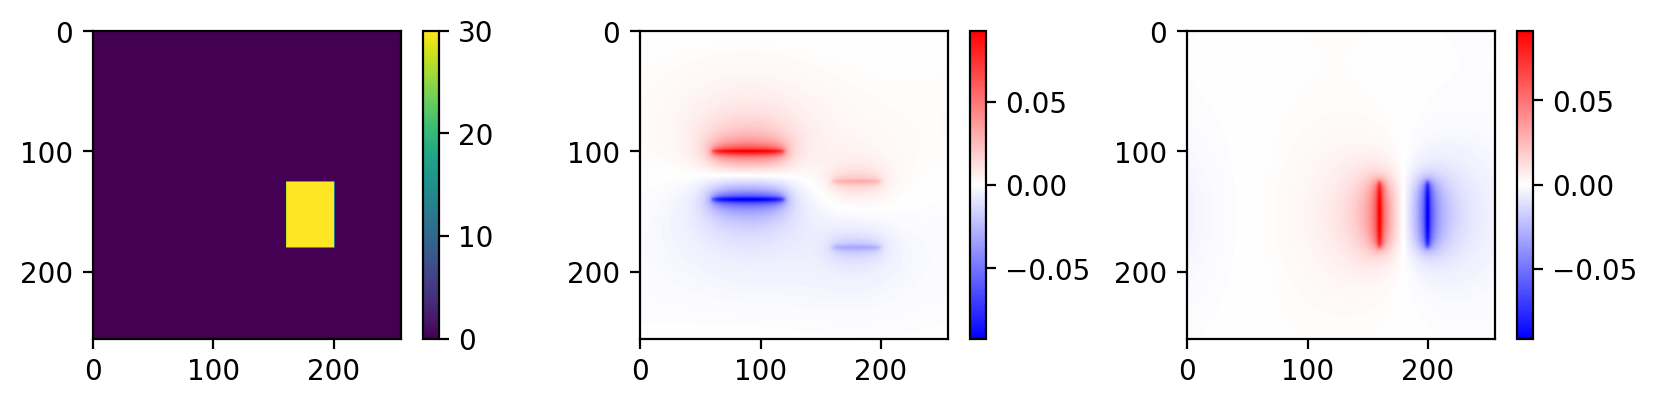

In [8]:
MagX = np.zeros((256,256))
MagY = np.zeros((256,256))

# Shape 1
MagX[125:180,160:200] = 10
MagY[125:180,160:200] = 30
# shape 2
MagX[100:140,60:120] = 30
# MagY[100:140,60:180] = 0


# Distance is in um
dx = 0.1
dy = 0.1
sensor_theta = 0
sensor_phi = 0
height = 0.1
thickness = 0
# Transform the magnetisation into a magnetic field
dataset_mx = Data()
dataset_mx.load_data(MagX, dx, dy, -height, sensor_theta, sensor_phi, thickness)

magClass_mx = Mxy2Bsensor(dataset_mx, m_theta=90, m_phi=0)
magClass_my = Mxy2Bsensor(dataset_mx, m_theta=90, m_phi=90)
B_mx = magClass_mx.transform(M=torch.Tensor(MagX))
B_my = magClass_my.transform(M=torch.Tensor(MagY))

plt.figure(figsize=(10,2))
plt.subplot(131)
plt.imshow(MagY)
plt.colorbar()
plt.subplot(132)
plt.imshow(B_mx*1e3, cmap='bwr')
plt.colorbar()
plt.subplot(133)
plt.imshow(B_my*1e3, cmap='bwr')
plt.colorbar()

torch.FloatTensor
Applied a high frequency filter, removing all components smaller than 0.3 um


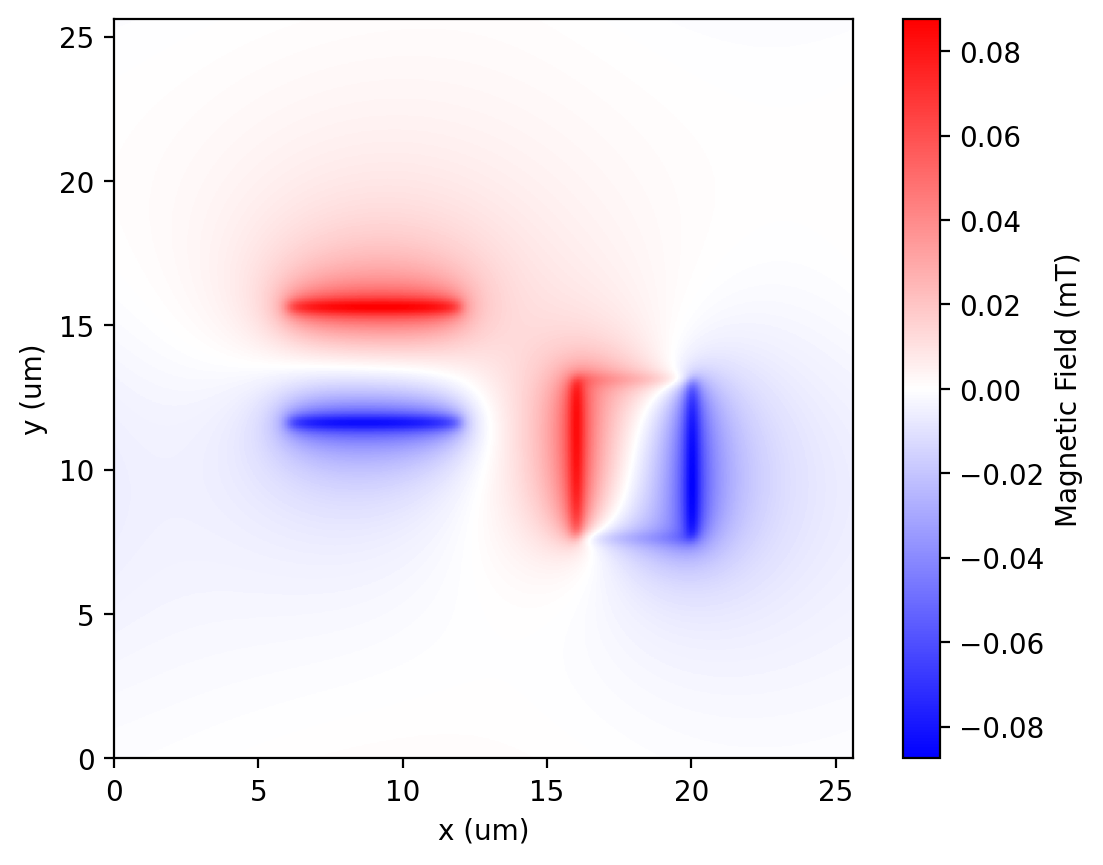

In [9]:
bnv = B_mx + B_my 
print(bnv.type())

dataset = Data()
dataset.load_data(bnv, dx, dy, height, sensor_theta, sensor_phi, thickness)

dataset.remove_DC_background()
# Add filter 
dataset.add_hanning_filter(0.3)
dataset.add_short_wavelength_filter(0.3)
# dataset.pad_data_to_power_of_two()
dataset.plot_target()


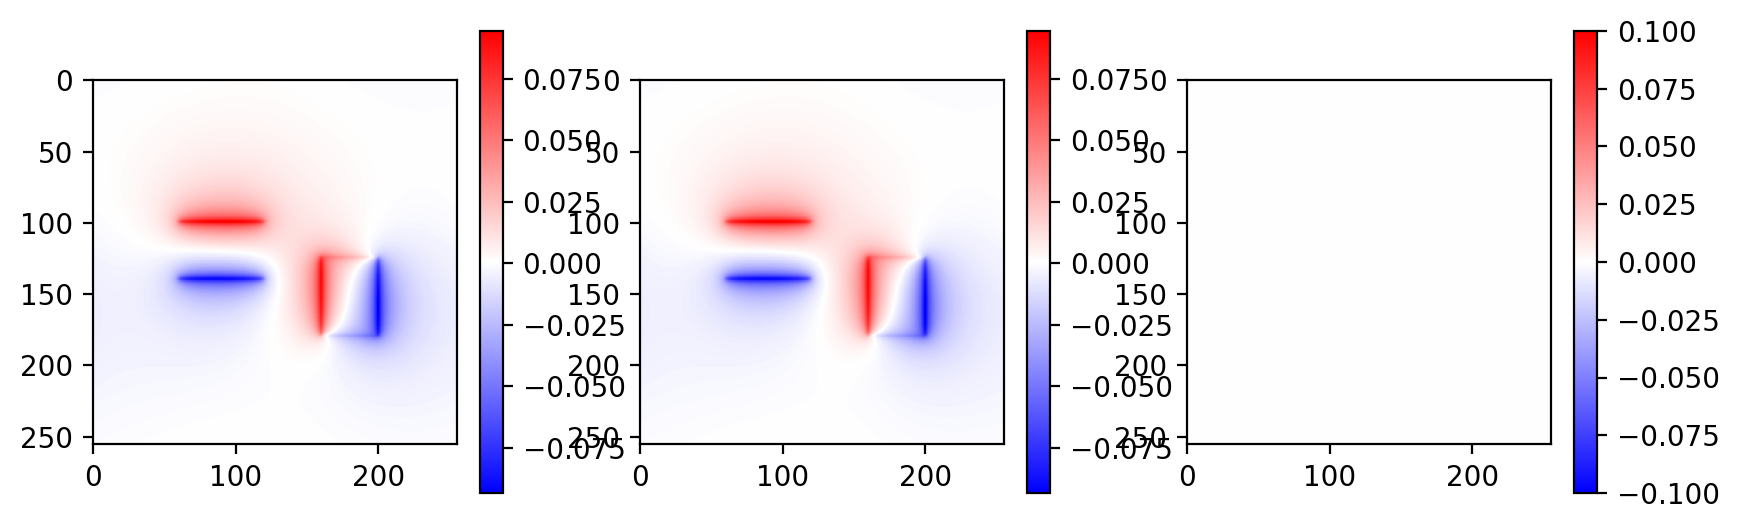

In [23]:
# Check that the transformation from magnetisation is working

# make a torch tensor with the two magnetisation images
Mxy_imgs = torch.Tensor(np.stack([MagX, MagY], axis=0))
Mxy_imgs = Mxy_imgs[np.newaxis, ...]

magClass_mxy = MxandMy2Bsensor(dataset_mx)
Bnv_test = magClass_mxy.transform(M=Mxy_imgs)


plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(bnv*1e3, cmap='bwr')
plt.colorbar()
plt.subplot(132)
plt.imshow(Bnv_test*1e3, cmap='bwr')
plt.colorbar()

plt.subplot(133)
plt.imshow((bnv-Bnv_test)*1e3, cmap='bwr')
plt.colorbar()

In [28]:
# source_wieght_1 = Masks.mask_hor_dir(dataset.target, 0.5e-5, plot=True)
# source_wieght_2 = Masks.mask_vert_dir(dataset.target, 1e-5, plot=True)
# source_wieght = np.ceil((source_wieght_1 + source_wieght_2)/3)

# source_wieght = np.zeros_like(dataset.target)
# source_wieght[20:220, 20:220] = 1
Model = Mxy(dataset, "MSE", 
                             scaling_factor = 1e6, 
                             std_loss_scaling = 0, 
                             positive_magnetisation = True,
                             loss_weight = None,
                            #  source_weight = torch.Tensor(source_wieght),
                             spatial_filter = False,
                             spatial_filter_width = [0.2, 0.2])



In [29]:
Model.plot_weights()

## Now we will try to reconstruct the magnetisation using a neural network.

Number of sources: 2
Number of targets: 1


c:\Users\E123108\AppData\Local\anaconda3\envs\magrec\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  2.41e+02
epoch    11 | loss on last mini-batch:  2.41e+02
epoch    21 | loss on last mini-batch:  2.38e+02
epoch    31 | loss on last mini-batch:  2.27e+02
epoch    41 | loss on last mini-batch:  1.98e+02
epoch    51 | loss on last mini-batch:  1.50e+02
epoch    61 | loss on last mini-batch:  9.06e+01
epoch    71 | loss on last mini-batch:  4.02e+01
epoch    81 | loss on last mini-batch:  8.21e+00
epoch    91 | loss on last mini-batch:  2.40e+00


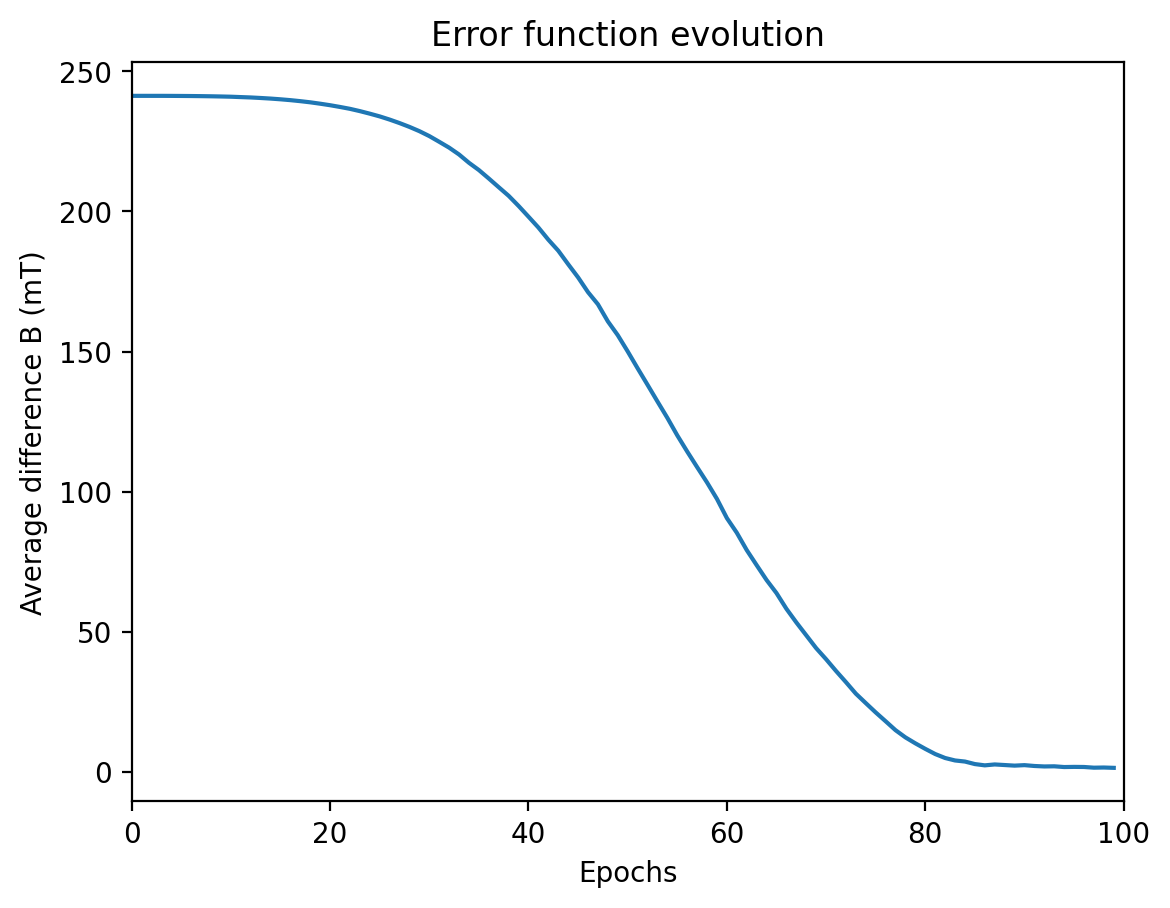

In [30]:
FittingMethod = CNN(Model, learning_rate=0.1)
FittingMethod.fit(n_epochs=100)
FittingMethod.plot_loss()

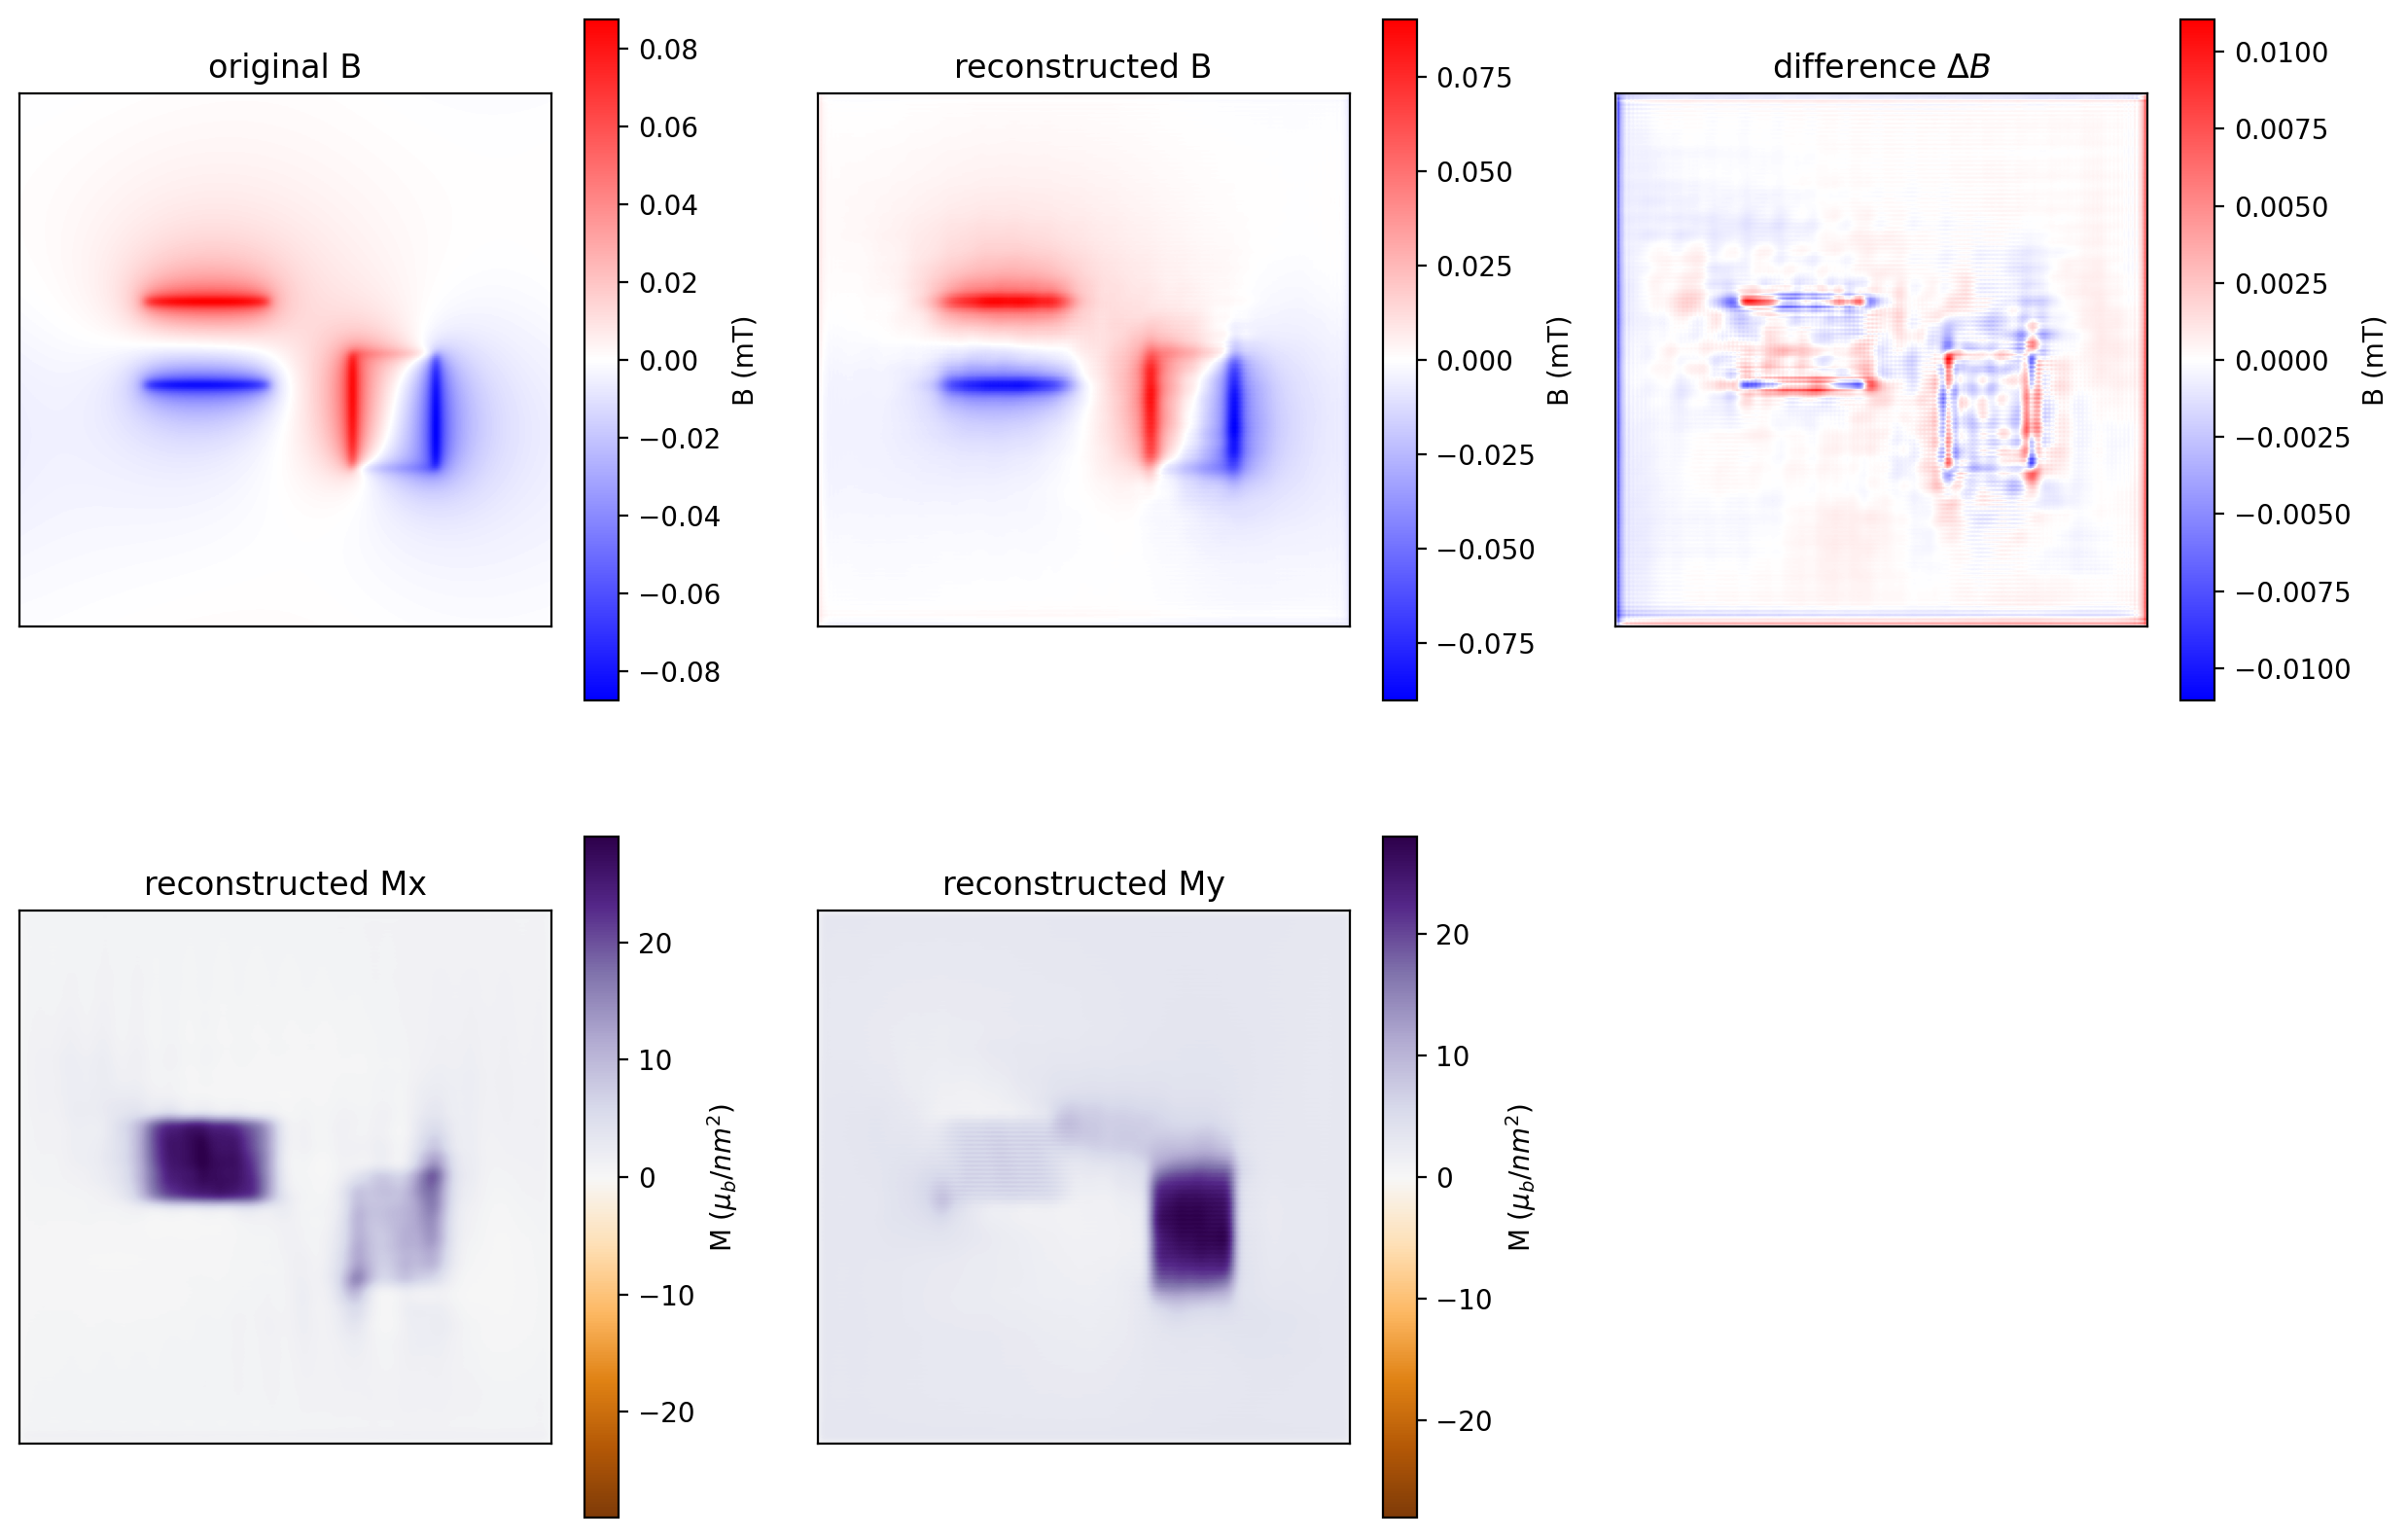

In [31]:
FittingMethod.extract_results(remove_padding=False)
FittingMethod.plot_results()

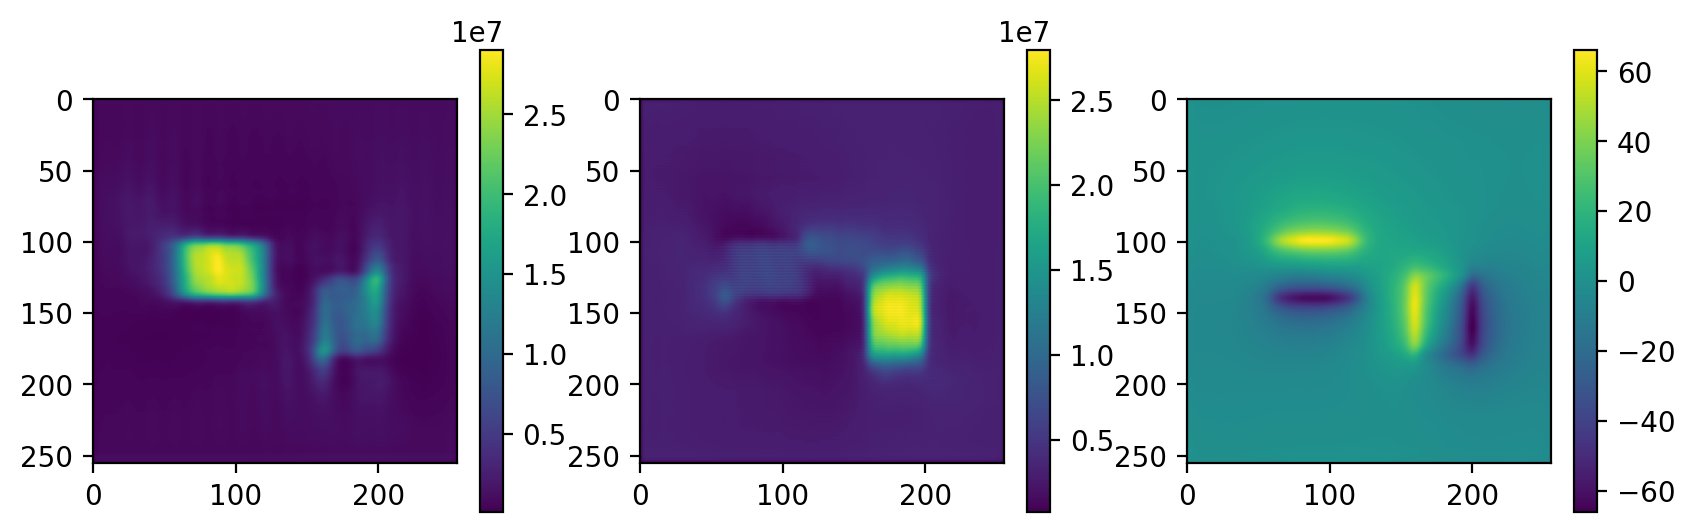

: 

In [32]:

Bnv_final_check = magClass_mxy.transform(M=FittingMethod.final_output)


plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(FittingMethod.final_output[0,0,::])
plt.colorbar()
plt.subplot(132)
plt.imshow(FittingMethod.final_output[0,1,::])
plt.colorbar()

plt.subplot(133)
plt.imshow(Bnv_final_check)
plt.colorbar()